# Week 5- Specialized Neural Networks: CNNs and RNNs

* What is convolution in general?
* What is a convolutional layer?
* If Feed-forward neural networks are genral, why do we even need CNNs?
* Build a NN for image classification using a FFNN and then a CNN
* Brief discussion of recurrant neural networks
    * Another example of a specialized network structure to handle a specific kind of data
    * Recently fallen out of favor after invention of transformers (discussed in 2nd half of semester)
 
#### Key Vocab:

* Neural Network Architecture
* Convolution
* Tensors
* Pooling Layer

In [2]:
# Imports used in this lesson

import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential


import tensorflow_datasets as tfds

2025-02-07 02:34:35.138869: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 02:34:35.149791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738895675.163529      28 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738895675.167703      28 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 02:34:35.181654: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## What is a Convolution?

> _Convolution_ can be thought of as a way to create new functions from old ones, alongside the familiar methods of addition, multiplitcaion, and composition of functions.
> 
From "Harmonic Analysis: From Fourier to Wavelets" Maria Cristina Pereyra & Lesley A. Ward

**Definition**

> For two functions $f$, $g$: $\mathbb{R} \to \mathbb{R}$, the _convolution_ of $f$ and $g$ (written $f * g$) is defined as
>
> $$(f * g)(t) = \int_{-\infty}^\infty f(\theta)\cdot g(t - \theta) d\theta$$
>

We can think of convolution as an operation where we slide one function along the domain of another.

## Discrete Convolution

We will be using a slightly different type of convolution operation, the _discrete convolution_.

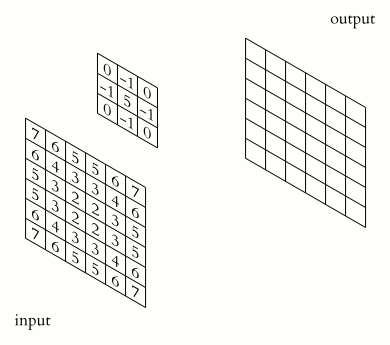
> Image From Wikipedia

The discrete convolution take the idea of the continuous convolution and applies it to vectors, matrices, or higher order tensors.
We can define (1-D) version similarly to the continuous convolution:

$$(A * B)[n] = \sum_{m = -\infty}^\infty A[m] \cdot B[n - m]$$

Where here we consider $A[n]$ to be equal to zero for $n$ outside $A$'s shape.


## Convolution and Image Processing

Convolution plays a vital role in the field of image processing, and thus any neural network dealing with image data.

**Definition**

> In the context of a convolution, particularly in Convolutional Neural Networks (CNNs), a **kernel** (also called a **filter**) is a small matrix of weights that is applied to an input (such as an image or feature map) to extract specific features. The kernel slides (or convolves) across the input, performing an element-wise multiplication with the values it overlaps, followed by summing up the results to produce a single output value. This process is repeated across the entire input, creating an output feature map.

### Key Characteristics of a Kernel
- **Size:** The kernel typically has a small, fixed size (e.g., ($3 \times 3$), ($5 \times 5$)), smaller than the input dimensions.
- **Weights:** The values inside the kernel matrix are learnable parameters optimized during the training process.
- **Feature Extraction:** Different kernels can detect different types of features, such as edges, textures, or patterns.

### Example of Applying Convolution for Image Processing

Let's apply convolutions to an image in order to detect edges or blur the image, using these kernels:

$$
\left[
\begin{array}{ccc}
-1 & -1 & -1 \\
-1 & 8 & -1 \\
-1 & -1 & -1
\end{array}
\right]
\,\,\,\,\,\,\,
\left[
\begin{array}{ccc}
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9
\end{array}
\right]
$$

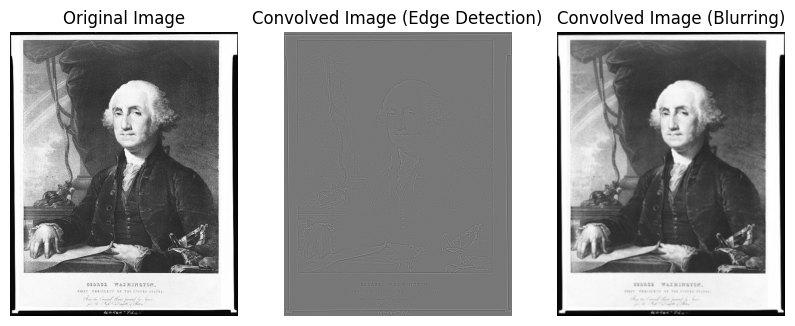

In [5]:
# Load an image as grayscale
image_path = "../images/Washington.jpg"  # Orignial image sourced from library of congress

image = Image.open(image_path).convert("L")  # Convert to grayscale
image_array = np.array(image)
image_array = image_array / 255

# Define kernels
kernel_edges = np.array([[-1, -1, -1],
                         [-1,  8, -1],
                         [-1, -1, -1]])

kernel_blur = 1.0 / 9.0 * np.ones((3, 3))

# Or, try this kernel for a more pronounced blurring effect:
# kernel_blur = 1.0 / (8.0**2) * np.ones((8, 8))


# Perform the convolution using scipy's convolve2d
convolved_image_edges = convolve2d(image_array, kernel_edges, mode='same', boundary='fill', fillvalue=0)
convolved_image_blur = convolve2d(image_array, kernel_blur, mode='same', boundary='fill', fillvalue=0)

# Plot the original and convolved images
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Convolved Image (Edge Detection)")
plt.imshow(convolved_image_edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Convolved Image (Blurring)")
plt.imshow(convolved_image_blur, cmap='gray')
plt.axis('off')

plt.show()


## Convolutional Neural Networks

We have seen that convolution can be used to transform one images into another in a way that extracts certain information about that image or makes aspects of the image more apparent.
It can be fun or interesting to try to think up different kinds of kernels and what sorts of features that kernel would identify.
However, we can use the power of deep learning and gradient descent to _learn_ the weights of the kernel instead of specifying them directly.
This is the key idea of a _convolutional neural network_ or CNN.

Let's go through a basic example of a CNN using the famous MNIST dataset.

[Keras Convolutional Layer Documentation](https://keras.io/api/layers/convolution_layers/convolution2d/)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


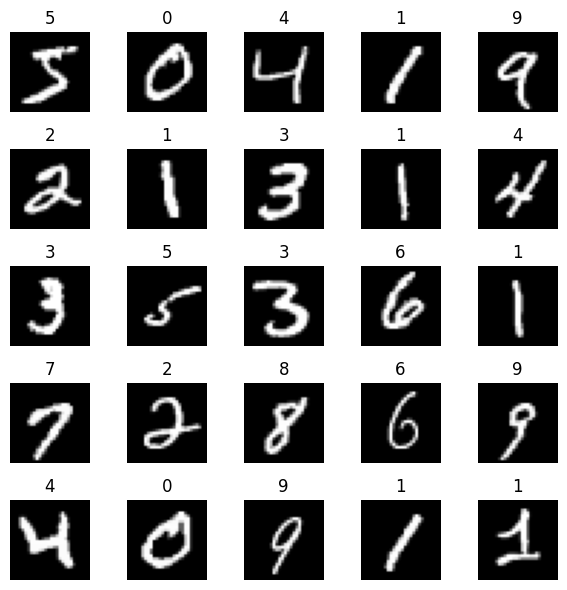

In [3]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Display a few images from the dataset

plt.figure(figsize=(6, 6))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')
plt.tight_layout()

In [4]:
# Create the model

model = Sequential()

model.add(layers.Input((28, 28, 1)))
model.add(layers.Conv2D(10, kernel_size=3, activation='relu'))  # The '10' here means we will have 10 unique kernels
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

W0000 00:00:1738702557.094492      98 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        67,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,710 (264.49 KB)

 Trainable params: 67,710 (264.49 KB)

 Non-trainable params: 0 (0.00 B)

**Note:** In this section, we will only do the training for a single epoch, so that we do not have to wait very long for results.
In normal situations, we would train for more epochs.

In [5]:
# Train the model

print("Training...")

model.fit(X_train, y_train)

Training...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.6108


Prediction...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.9579


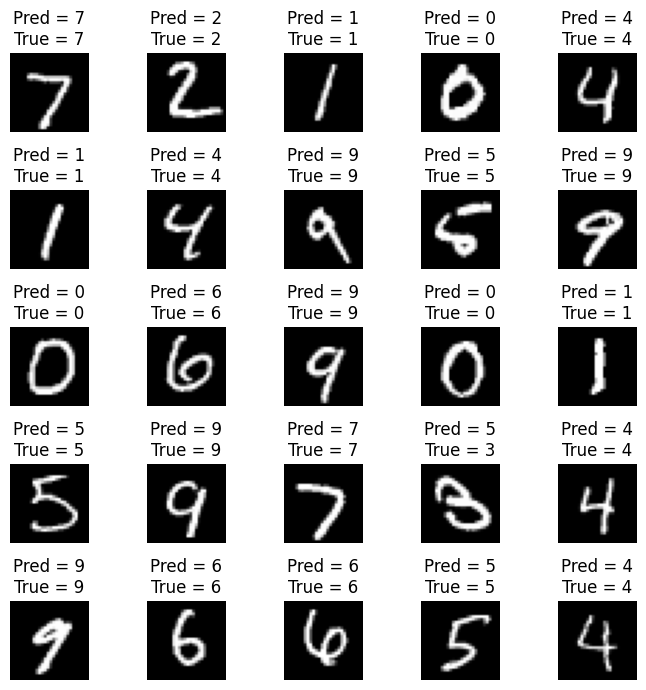

In [6]:
# Make test predictions:

print("Prediction...")

y_hat_test = model.predict(X_test)
y_hat_test_prediction = np.argmax(y_hat_test, axis=1)

acc = (y_hat_test_prediction == y_test).mean()

print("Test Accuracy:" , acc)

# Show some predictions

plt.figure(figsize=(7, 7))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"Pred = {y_hat_test_prediction[i]}\nTrue = {y_test[i]}")
    plt.axis('off')
plt.tight_layout()

## Multichannel Images



## Deep CNNS

In the previous section, we saw that a convolutional neural network can be used for image classification tasks.
CNNS are great for such tasks, but can run into issues when dealing with larger images.
As with generic feed-forward networks, we can start by stacking more convolutional layers into out model.

In [8]:
model = Sequential()

model.add(layers.Input((28, 28, 1)))
model.add(layers.Conv2D(10, kernel_size=7, activation='relu'))
model.add(layers.Conv2D(10, kernel_size=5, activation='relu'))
model.add(layers.Conv2D(10, kernel_size=3, activation='relu'))
model.add(layers.Flatten())

# Also add some more fully connected layers at the end
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 10)     │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 10)     │         2,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       163,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,474 (658.10 KB)

 Trainable params: 168,474 (658.10 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.fit(X_train, y_train)

y_hat_test = model.predict(X_test)
y_hat_test_prediction = np.argmax(y_hat_test, axis=1)

acc = (y_hat_test_prediction == y_test).mean()

print("Model accuracy:", acc)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.1389
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model accuracy: 0.9702


This results in a moderate improvement in accuracy.

## Pooling Layers

Convolutional neural networks worked very well when dealing with small images like in the MNIST dataset.
However, problems can arise when we want to instead look at larger images.
To address this issue, we can turn to _pooling layers_.
Keras provides two main types of pooling layers: max pooling and average pooling.
In most cases, max pooling provides the best results.

In [10]:
# Here we will use the MaxPool2D layer since we are using 2D inputs.
example_max_pool = layers.MaxPool2D(pool_size=2)

# These reshape calls are required to make the MaxPool2D layer work as required

example_input = np.array([
    [10, 1, 2, 3],
    [0, -5, 6, 8],
    [4, 1, 2, 1],
    [-6, -8, -10, 6],
]).reshape(1, 4, 4, 1)

example_max_pool(example_input).numpy().reshape(2, 2)

array([[10,  8],
       [ 4,  6]])

Here we can see the output of a pooling layer.
The layer looks at each sub-matrix (in this case, each $2 \times 2$ sub-matrix) and returns the largest entry.

### Example using Max Pooling layers

In [74]:
# Load dataset
dataset_name = 'tf_flowers'
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, 
    split=['train[:80%]', 'train[80%:]'],  # 80% train, 20% test
    as_supervised=True,  # Returns (image, label) pairs
    with_info=True
)

# Print dataset info
print(ds_info)

class_names = ds_info.features['label'].names

# Apply pre-processing to the images

IMG_SIZE = 224

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize
    image = tf.cast(image, tf.float32) / 255.0  # Normalize (0-1 range)
    return image, label

# Apply preprocessing to datasets
ds_train = ds_train.map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


2025-02-05 16:44:36.575543: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-02-05 16:44:36.576214: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


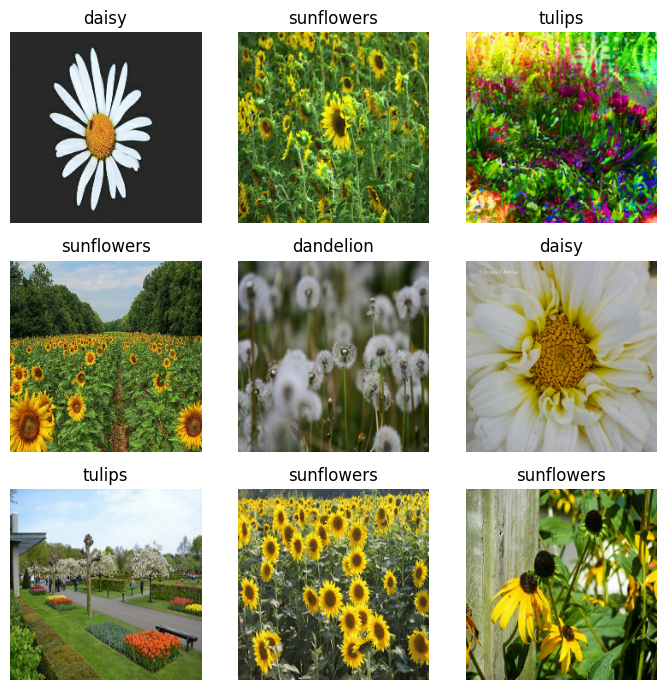

In [81]:
# Look at some example images

images, labels = next(ds_train.cache().take(9).as_numpy_iterator())


plt.figure(figsize=(7, 7))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.tight_layout()

In [82]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)  # Width x Height x Color
num_classes = ds_info.features['label'].num_classes


model = Sequential([
    layers.Input(input_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,681,093 (36.93 MB)

 Trainable params: 9,681,093 (36.93 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
history = model.fit(ds_train, validation_data=ds_test, epochs=10, batch_size=256)  # This one takes more epochs.

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.3245 - loss: 1.7116 - val_accuracy: 0.5531 - val_loss: 1.1017
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.5542 - loss: 1.1163 - val_accuracy: 0.5627 - val_loss: 1.0828
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.5976 - loss: 1.0056 - val_accuracy: 0.6308 - val_loss: 0.8892
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.6678 - loss: 0.8607 - val_accuracy: 0.6390 - val_loss: 0.8944
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.7114 - loss: 0.7429 - val_accuracy: 0.6471 - val_loss: 0.8769
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.7501 - loss: 0.6699 - val_accuracy: 0.6608 - val_loss: 0.8315
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.7818 - loss: 0.5498 - val_accuracy: 0.6798 - val_loss: 0.8713
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.8551 - loss: 0.4195 - val_accu

## Why Bother With CNNs at all?

A natural question to ask is
> _Why bother with CNNs at all when we already know (thanks to our friend the universal approximation theorem) that a fully-connected network should be good enough?_

Let's explore why a convolution is so useful for image data:

Just because something is *theoretically* possible doesn’t mean it’s *practical*.
Here’s why Convolutional Neural Networks (CNNs) are still necessary:

**Parameter Efficiency & Scalability**
- Fully connected networks treat all input features as independent, which leads to an explosion in parameters, especially for high-dimensional data like images.  
- CNNs leverage **local connectivity** and **weight sharing**, drastically reducing the number of parameters compared to FCNs. For example, a 256×256 image with three color channels (RGB) has nearly 200,000 input features—an FCN would require an enormous number of weights.

**Spatial Hierarchies & Feature Extraction**
- Images and many other types of structured data contain **local patterns** (edges, textures, shapes, objects).  
- CNNs use **convolutions** to detect small patterns first, then progressively combine them into larger structures. This hierarchical feature learning allows CNNs to generalize well, unlike FCNs, which have to learn everything from scratch.

**Translation Invariance & Robustness**
- Convolutional layers apply **shared filters** across the entire input space, making CNNs **translation-invariant**—meaning they recognize objects regardless of where they appear in the image.  
- FCNs, in contrast, lack this property and would require significantly more training data to generalize across shifts in object position.

**Better Generalization & Faster Training**
- Due to their inductive biases (i.e., **locality and weight sharing**), CNNs generalize better than FCNs with the same number of parameters.  
- This also leads to **faster convergence** and better performance with less training data compared to FCNs.

**Computational Efficiency & Hardware Optimization**
- Convolutions involve a **fixed number of parameters per filter**, making CNNs much more computationally efficient than FCNs, which have dense matrix multiplications.  
- Modern hardware (e.g., GPUs and TPUs) is highly optimized for convolution operations, making CNNs much faster and more scalable in practice.

Yes, an FCN *could* theoretically approximate any function given enough neurons and training data.
But in the real world, CNNs achieve the same or better results **with far fewer parameters, better generalization, and much greater computational efficiency**.
That’s why we use CNNs for tasks like image recognition, medical imaging, and many other structured data problems.


## Recurrent Neural Networks

We will turn our attention to recurrent neural networks (RNNs).
This style of newtwork has fallen out of favor in the last few years due to the rise of transformers, which we will study in the 2nd half of this semseter.
Nevertheless, RNNs can serve as a useful learning example of modifying

### The Problem RNNs Solve

Many real-world problems require context from previous inputs to make accurate predictions. For example:

* In language modeling, understanding previous words helps predict the next word.
* In stock price prediction, past prices influence future trends.
* In speech recognition, earlier phonemes affect the interpretation of later ones.

### How RNNs Address This Problem

RNNs introduce loops (or recurrence) in their architecture, allowing information to persist across time steps:

* They process sequential data one step at a time, maintaining a hidden state that carries information from previous steps.
* At each step, the current input and the previous hidden state are combined to produce an updated hidden state.
* This allows RNNs to learn dependencies over time, making them well-suited for sequence-based tasks.

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3809 - val_loss: 0.0081
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 4.5095e-04
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4193e-04 - val_loss: 6.3743e-05
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1093e-05 - val_loss: 2.0542e-05
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


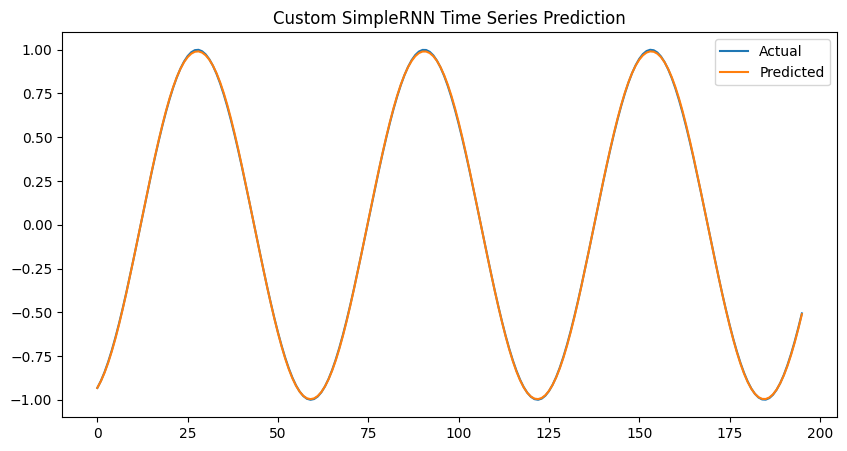

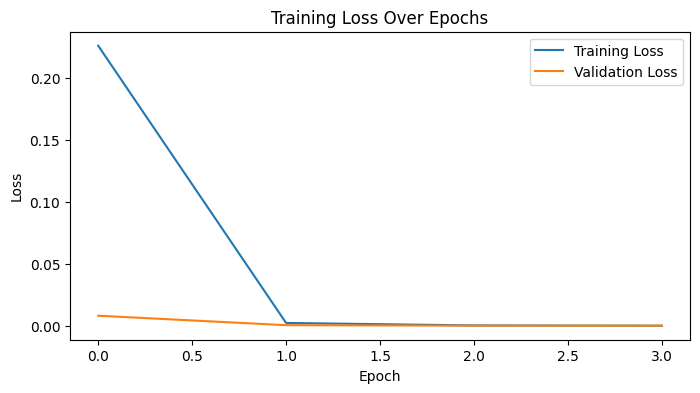

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Generate a sine wave dataset
def generate_sine_wave(seq_length, num_samples):
    X, y = [], []
    x_values = np.linspace(0, 100, num_samples)
    sine_wave = np.sin(x_values)

    for i in range(len(sine_wave) - seq_length):
        X.append(sine_wave[i:i + seq_length])
        y.append(sine_wave[i + seq_length])

    return np.array(X), np.array(y)

# Hyperparameters
SEQ_LENGTH = 20  # Number of time steps
NUM_SAMPLES = 1000  # Total number of points
HIDDEN_SIZE = 10  # Hidden state size
LEARNING_RATE = 0.01
EPOCHS = 4
BATCH_SIZE = 16

# Generate dataset
X, y = generate_sine_wave(SEQ_LENGTH, NUM_SAMPLES)

# Reshape data for RNN input
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((y.shape[0], 1))

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---- Manually Implementing SimpleRNN ----
class CustomSimpleRNN(tf.keras.layers.Layer):
    def __init__(self, hidden_size, **kwargs):
        super(CustomSimpleRNN, self).__init__(**kwargs)
        self.hidden_size = hidden_size

    def build(self, input_shape):
        """Initialize trainable parameters"""
        feature_dim = input_shape[-1]  # Number of input features

        # Initialize weights
        self.Wxh = self.add_weight(shape=(feature_dim, self.hidden_size), initializer="random_normal", trainable=True)
        self.Whh = self.add_weight(shape=(self.hidden_size, self.hidden_size), initializer="random_normal", trainable=True)
        self.bh = self.add_weight(shape=(self.hidden_size,), initializer="zeros", trainable=True)

        self.Why = self.add_weight(shape=(self.hidden_size, 1), initializer="random_normal", trainable=True)
        self.by = self.add_weight(shape=(1,), initializer="zeros", trainable=True)

    def call(self, inputs):
        """Forward pass through the manually implemented SimpleRNN"""
        batch_size = tf.shape(inputs)[0]
        hidden_state = tf.zeros((batch_size, self.hidden_size))  # Initialize hidden state to zero

        # Process the input sequence step by step
        for t in range(SEQ_LENGTH):
            xt = inputs[:, t, :]  # Extract the t-th time step
            hidden_state = tf.tanh(tf.matmul(xt, self.Wxh) + tf.matmul(hidden_state, self.Whh) + self.bh)

        # Compute final output
        output = tf.matmul(hidden_state, self.Why) + self.by
        return output

# ---- Building the Full Model with the Custom RNN ----
inputs = Input(shape=(SEQ_LENGTH, 1))  # Input layer
hidden = CustomSimpleRNN(HIDDEN_SIZE)(inputs)  # Custom RNN Layer
output = Dense(1)(hidden)  # Output layer

model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="mse")

# Train the model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label="Actual")
plt.plot(range(len(y_pred)), y_pred, label="Predicted")
plt.legend()
plt.title("Custom SimpleRNN Time Series Prediction")
plt.show()

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Citations

**Need to include citations for all datasets used in this lesson.**

# Homework Questions

1. What is convolution? Why would it make sense for a neural network to share weights? Why are convolutional layers good choices for neural networks woking with image data?
2. Load the fashion MNIST dataset. Train a CNN neural network to predict the class of images.
3. Load the stock dataset. Create a recurrent neural network to predict the next day's closing stock price.